In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter("ignore")

In [4]:
temperature = pd.read_excel("temperature_gaz_dataset.xlsx", sheet_name="temperature", dtype={'date_date': int})
co2 = pd.read_excel("temperature_gaz_dataset.xlsx", sheet_name="co2", dtype={'date_date': int})
ch4 = pd.read_excel("temperature_gaz_dataset.xlsx", sheet_name="ch4", dtype={'date_date': int})
no2 = pd.read_excel("temperature_gaz_dataset.xlsx", sheet_name="no2", dtype={'date_date': int})

In [5]:
# Need to find the common start and end dates of the dataset

max_date_date = min(temperature['date_date'].max(),co2['date_date'].max(),no2['date_date'].max(),ch4['date_date'].max())
display(max_date_date)

min_date_date = max(temperature['date_date'].min(),co2['date_date'].min(),no2['date_date'].min(),ch4['date_date'].min())
display(min_date_date)

2015

-796050

In [6]:
# Create a list of years, starting from the minimum date and ending with the maximum
# Use this list to create a DataFrame

years = list(range(min_date_date, max_date_date + 1))
df_all = pd.DataFrame({'date_date': years})

In [7]:
# Merge the datasets

df_all=pd.merge(df_all, temperature, on="date_date", how="left")
df_all = pd.merge(df_all, co2, on='date_date', how='left')
df_all = pd.merge(df_all, ch4, on='date_date', how='left')
df_all = pd.merge(df_all, no2, on='date_date', how='left')
df_all

,date_date,temperature,co2,ch4,no2
0,-796050,-1.684176,NaN,NaN,NaN
1,-796049,NaN,NaN,NaN,NaN
2,-796048,NaN,NaN,NaN,NaN
3,-796047,NaN,NaN,NaN,NaN
4,-796046,NaN,NaN,NaN,NaN
...,...,...,...,...,...
798061,2011,0.600000,391.63,1803.14,323.352333
798062,2012,0.630000,393.82,1808.03,324.395083
798063,2013,0.650000,396.48,1813.43,325.219667
798064,2014,0.740000,398.61,1822.61,326.198333


In [8]:
# Perform interpolation and backfilling on the merged data, the aim is to fill in any missing values

df_all = df_all.interpolate().interpolate(method="backfill")
df_all

,date_date,temperature,co2,ch4,no2
0,-796050,-1.684176,188.40,396.00,248.800000
1,-796049,-1.684434,188.40,396.00,248.800000
2,-796048,-1.684692,188.40,396.00,248.800000
3,-796047,-1.684950,188.40,396.00,248.800000
4,-796046,-1.685208,188.40,396.00,248.800000
...,...,...,...,...,...
798061,2011,0.600000,391.63,1803.14,323.352333
798062,2012,0.630000,393.82,1808.03,324.395083
798063,2013,0.650000,396.48,1813.43,325.219667
798064,2014,0.740000,398.61,1822.61,326.198333


In [9]:
# interpolate() performs forward interpolation, which estimates missing values based on the values 
# that come after them in the dataset

# interpolate(method="backfill") applies backfilling. Backfilling fills in missing values with the next available 
# non-missing value in the dataset. This method is useful when there are consecutive missing values

In [10]:
# Focus on the last 150 years

df_all_last_150=df_all.tail(150)

In [11]:
# Create a correlation matrix to examine the relationships between temperature, CO2, CH4, and NO2, and visualize it 
# using a heatmap

corr_matrix= df_all_last_150[["temperature", "co2", "ch4", "no2"]].corr()
corr_matrix

,temperature,co2,ch4,no2
temperature,1.000000,0.928968,0.885056,0.925038
co2,0.928968,1.000000,0.950862,0.997823
ch4,0.885056,0.950862,1.000000,0.964885
no2,0.925038,0.997823,0.964885,1.000000


<Axes: >

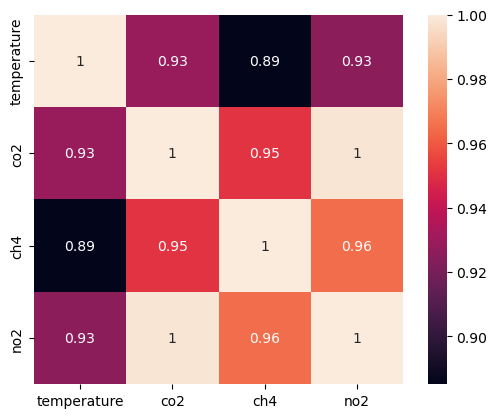

In [12]:
sns.heatmap(corr_matrix,annot=True, square=True)

In our project, the focus on temperature and CO2 emission changes in the last 150 years. Also want to highlight 
specific historical periods, such as the start and expansion of the first coal-fired power station (highlighted in lime), 
the First World War (highlighted in blue), and the Second World War (highlighted in purple), through visualizations 

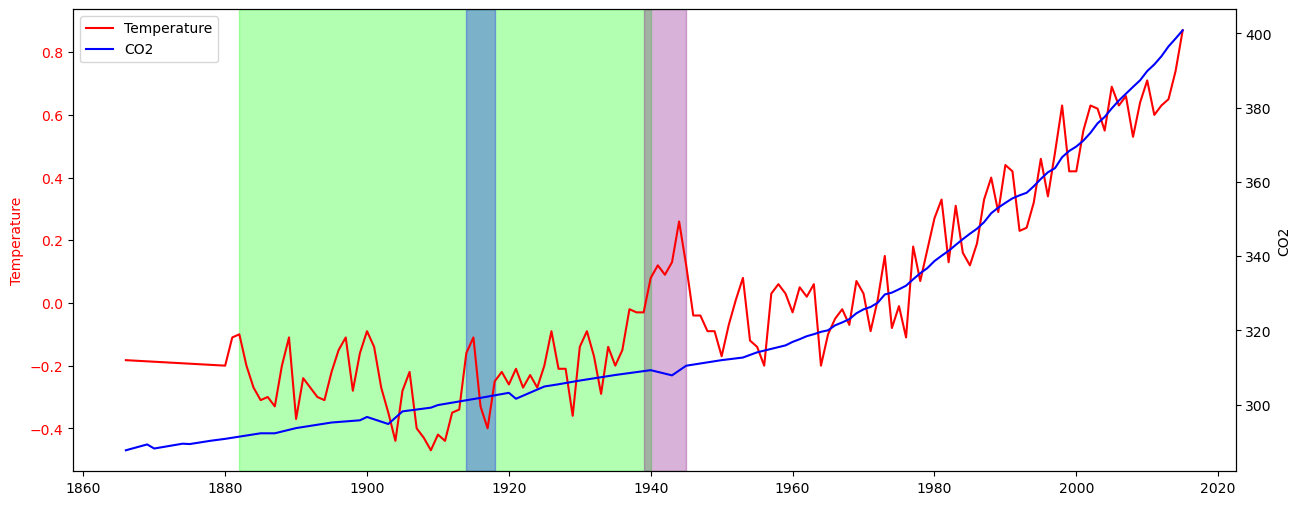

In [13]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(df_all_last_150['date_date'], df_all_last_150['temperature'], label='Temperature', color='red')
ax1.set_ylabel('Temperature', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(df_all_last_150['date_date'], df_all_last_150['co2'], label='CO2', color='blue')

ax2.set_ylabel('CO2', color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')


# ax1.axvspan(1760, 1840, color="green", alpha=0.3)  # industrial rev.
ax1.axvspan(1882, 1940, color="lime", alpha=0.3)   #start of the first coal fired power station and expenstion
ax1.axvspan(1914, 1918, color="blue", alpha=0.3)   # I WW
ax1.axvspan(1939, 1945, color="purple", alpha=0.3)   # II WW


plt.show()

Our objective is to develop a predictive model for estimating CO2 emissions and if possible also the temperature.

In [14]:
# Keep only temperature and co2

df_150y_for_pred= df_all_last_150[["date_date","temperature","co2"]]
df_150y_for_pred

,date_date,temperature,co2
797916,1866,-0.18250,287.725
797917,1867,-0.18375,288.250
797918,1868,-0.18500,288.775
797919,1869,-0.18625,289.300
797920,1870,-0.18750,288.200
...,...,...,...
798061,2011,0.60000,391.630
798062,2012,0.63000,393.820
798063,2013,0.65000,396.480
798064,2014,0.74000,398.610


In [15]:
df_150y_for_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 797916 to 798065
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date_date    150 non-null    int64  
 1   temperature  150 non-null    float64
 2   co2          150 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.7 KB


In [16]:
# Rename coulmn 

df_150y_for_pred.rename(columns={"date_date":"year"}, inplace= True)

CO2 prediction

In [17]:
# Keep only co2

df_150y_for_pred_co2= df_all_last_150[["date_date","co2"]]
df_150y_for_pred_co2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 797916 to 798065
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_date  150 non-null    int64  
 1   co2        150 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [18]:
# # Rename coulmn and change the year to datetime

df_150y_for_pred_co2.rename(columns={"date_date":"year"}, inplace= True)
df_150y_for_pred_co2["year"] = pd.to_datetime(df_150y_for_pred_co2["year"], format="%Y")

In [19]:
df_150y_for_pred_co2.head()

,year,co2
797916,1866-01-01,287.725
797917,1867-01-01,288.250
797918,1868-01-01,288.775
797919,1869-01-01,289.300
797920,1870-01-01,288.200


In [20]:
# Split the dataset into train and test

train = df_150y_for_pred_co2[df_150y_for_pred_co2["year"] < datetime(2011, 1, 1)].copy()
test = df_150y_for_pred_co2[df_150y_for_pred_co2["year"] >= datetime(2011, 1, 1)].copy()


In [21]:
# The goal to predict CO" emissions for the next 30 years unsing a linear regression model

train_ = train[['year', 'co2']].copy().set_index('year').squeeze()

lag=1
forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=lag)

forecaster.fit(y=train_)

years= 30

predictions = forecaster.predict(steps=years)

In [22]:
predictions

1     392.155952
2     394.512298
3     396.920140
4     399.380604
5     401.894839
6     404.464020
7     407.089349
8     409.772052
9     412.513384
10    415.314625
11    418.177085
12    421.102101
13    424.091042
14    427.145303
15    430.266312
16    433.455529
17    436.714443
18    440.044578
19    443.447491
20    446.924771
21    450.478045
22    454.108972
23    457.819250
24    461.610614
25    465.484834
26    469.443723
27    473.489129
28    477.622945
29    481.847101
30    486.163574
Name: pred, dtype: float64

In [23]:
# Create a dataFrame from the predicted values 

start_year = test['year'].iloc[0].year
years = 30
end_year = start_year + years
forecast_years = pd.date_range(start=datetime(start_year, 1, 1), periods=years, freq='AS')


df_forecast = pd.DataFrame({'year': forecast_years, 'co2': predictions})
df_forecast.head()

,year,co2
1,2011-01-01,392.155952
2,2012-01-01,394.512298
3,2013-01-01,396.920140
4,2014-01-01,399.380604
5,2015-01-01,401.894839


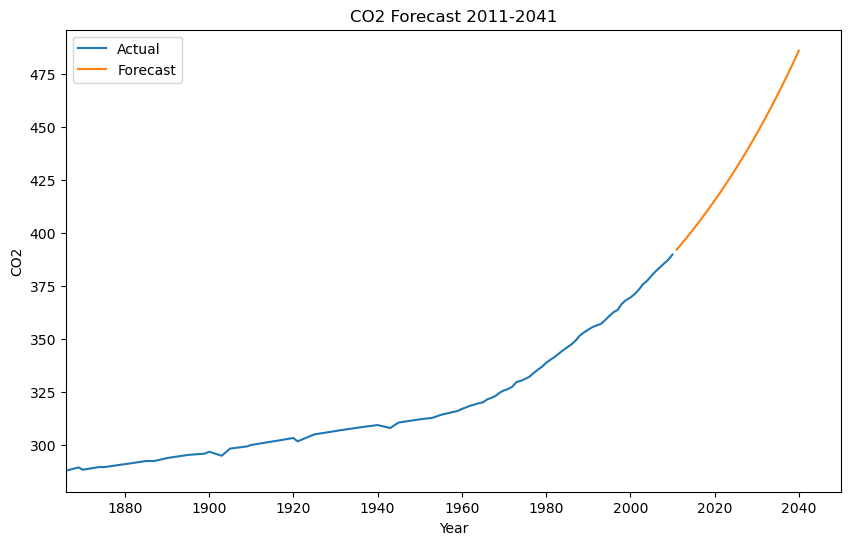

In [24]:
# Visualize past and predicted CO2 emissions for the next 30 years

plt.figure(figsize=(10, 6))
plt.plot(train_.index, train_, label='Actual')
plt.plot(df_forecast['year'], df_forecast['co2'], label='Forecast')

plt.xlim(train_.index[0], pd.to_datetime('2050'))

plt.xlabel('Year')
plt.ylabel('CO2')
plt.title('CO2 Forecast 2011-2041')
plt.legend()
plt.show()